In [107]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.animation as animation
import glob, re, os
import subprocess


import scipy.linalg as lng

from smt.applications import EGO
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS
from smt.applications import EGO
from smt.surrogate_models import KRG, XSpecs


import scienceplots
plt.style.use('default')
plt.style.use(['science', 'high-vis', 'grid'])

In [108]:
# PATH_BUILD_DIR = "/work/utox/users/helleboid_work_utox/OptiDopi/build/"
# PATH_COST_CPP = "/work/utox/users/helleboid_work_utox/OptiDopi/build/apps/spad_cost_function"

PATH_BUILD_DIR = "/home/remi/DEV/OptiDopi/build/"
PATH_COST_CPP = "/home/remi/DEV/OptiDopi/build/apps/spad_cost_function"
RES_FILE = "RES/res_cost_func.csv"
os.makedirs("EGO_Results/", exist_ok=True)
# Recompile the code first.
#subprocess.run(["make", f"-j 32"], cwd=PATH_BUILD_DIR)

In [109]:
def function_test_1d(doping_acceptor):
    doping_donor = 20.0
    length_intrinsic = 0.0
    subprocess.run([PATH_COST_CPP, f"{length_intrinsic}", f"{doping_donor}",f"{doping_acceptor}", RES_FILE])
    length_intrinsic, doping_donor, doping_acceptor, total_cost = np.loadtxt(RES_FILE, delimiter=",", unpack=True)
    print(f"Cost function: {total_cost}")
    return total_cost

def function_test_2d(PARAMS):
    #print(PARAMS)
    Y = []
    for idx in range(len(PARAMS)):
        length_intrinsic = PARAMS[idx,0]
        #print(f'{length_intrinsic=}')
        log_doping_acceptor =  PARAMS[idx,1]
        subprocess.run([PATH_COST_CPP, f"{length_intrinsic}", f"{log_doping_acceptor}", RES_FILE])
        length_intrinsic,doping_acceptor, BV,BrP,DW,BV_cost,BP_cost,DW_cost,total_cost = np.loadtxt(RES_FILE, delimiter=",", unpack=True)
        Y.append(total_cost)
        print(f"Total cost: {total_cost}")
    return np.array(Y)

vfunc1d = np.vectorize(function_test_1d)

vfunc2d = np.vectorize(function_test_2d)


In [110]:
min_length_intrinsic = 0.0
max_length_intrinsic = 0.0
min_log_acceptor = 16.5
max_log_acceptor = 17.5


n_iter = 100
xlimits = np.array([[min_log_acceptor, max_log_acceptor]])
xspecs = XSpecs(xlimits=xlimits)
xdoe = np.atleast_2d(np.random.uniform(min_log_acceptor, max_log_acceptor, 2)).T
n_doe = xdoe.size

criterion = "EI"  #'EI' or 'SBO' or 'LCB'*

In [111]:
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=KRG(xspecs=xspecs, print_global=False),
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=vfunc1d)
print("Minimum in x={:.1f} with f(x)={:.1f}".format(float(x_opt), float(y_opt)))

Initial FoM: BV = 28.39 V, BP = 55.32 %, DW =  1.01 um
Cost function: 3357544000.0
Initial FoM: BV = 28.39 V, BP = 55.32 %, DW =  1.01 um
Cost function: 3357544000.0
Initial FoM: BV = 28.39 V, BP = 56.99 %, DW =  1.01 um
Cost function: 3357523000.0
Initial FoM: BV = 27.45 V, BP = 55.40 %, DW =  0.94 um
Cost function: 1035403000.0
Initial FoM: BV = 27.45 V, BP = 55.40 %, DW =  0.94 um
Cost function: 1035403000.0
Initial FoM: BV = 25.59 V, BP = 56.69 %, DW =  0.87 um
Cost function: 58552100.0
Initial FoM: BV = 25.59 V, BP = 56.69 %, DW =  0.87 um
Cost function: 58552100.0
Initial FoM: BV = 23.50 V, BP = 57.76 %, DW =  0.74 um
Cost function: 536205.9
Initial FoM: BV = 23.50 V, BP = 57.76 %, DW =  0.74 um
Cost function: 536205.9
Initial FoM: BV = 21.64 V, BP = 58.74 %, DW =  0.67 um
Cost function: -1364.212
Initial FoM: BV = 21.64 V, BP = 58.74 %, DW =  0.67 um
Cost function: -1364.212
Initial FoM: BV = 11.87 V, BP = 68.11 %, DW =  0.20 um
Cost function: 2475898000.0
Initial FoM: BV = 11.8

In [112]:
x_line = np.linspace(min_log_acceptor, max_log_acceptor, 1000)
y_line = vfunc1d(x_line)

Initial FoM: BV = 28.62 V, BP = 56.13 %, DW =  1.01 um
Cost function: 4414481000.0
Initial FoM: BV = 28.62 V, BP = 56.13 %, DW =  1.01 um
Cost function: 4414481000.0
Initial FoM: BV = 28.62 V, BP = 56.53 %, DW =  1.01 um
Cost function: 4414476000.0
Initial FoM: BV = 28.39 V, BP = 54.26 %, DW =  1.01 um
Cost function: 3357945000.0
Initial FoM: BV = 28.39 V, BP = 54.71 %, DW =  1.01 um
Cost function: 3357582000.0
Initial FoM: BV = 28.39 V, BP = 55.16 %, DW =  1.01 um
Cost function: 3357549000.0
Initial FoM: BV = 28.39 V, BP = 55.60 %, DW =  1.01 um
Cost function: 3357537000.0
Initial FoM: BV = 28.39 V, BP = 56.04 %, DW =  1.01 um
Cost function: 3357530000.0
Initial FoM: BV = 28.39 V, BP = 56.47 %, DW =  1.01 um
Cost function: 3357526000.0
Initial FoM: BV = 28.39 V, BP = 56.90 %, DW =  1.01 um
Cost function: 3357524000.0
Initial FoM: BV = 28.15 V, BP = 54.61 %, DW =  1.01 um
Cost function: 2534139000.0
Initial FoM: BV = 28.15 V, BP = 55.06 %, DW =  1.01 um
Cost function: 2534075000.0
Init

In [113]:
x_min, y = x_line[np.argmin(y_line)], np.min(y_line)
print("Minimum in x={:.1f} with f(x)={:.1f}".format(float(x_min), float(y)))

Minimum in x=16.8 with f(x)=-1633.3


y_opt: [[3.35754563e+09]
 [3.35752463e+09]
 [1.03540463e+09]
 [5.85537333e+07]
 [5.37839204e+05]
 [2.69092000e+02]
 [2.47589963e+09]
 [5.44975930e+06]
 [1.31219730e+03]
 [1.84160833e+08]
 [1.89701863e+09]
 [1.89788333e+08]
 [5.43487433e+08]
 [2.47590163e+09]
 [1.78780030e+06]
 [9.42505863e+09]
 [9.11166430e+06]
 [2.72881633e+08]
 [3.76694233e+08]
 [1.37367163e+09]
 [4.31849563e+09]
 [2.47589663e+09]
 [1.84160533e+08]
 [1.19296000e+02]
 [9.45666600e+03]
 [3.87399433e+08]
 [3.17014330e+06]
 [3.17014030e+06]
 [5.80178040e+04]
 [1.19030000e+02]
 [1.37368063e+09]
 [3.87396033e+08]
 [8.51995533e+07]
 [1.48559033e+07]
 [1.20836000e+02]
 [1.37368263e+09]
 [5.80199840e+04]
 [1.32568000e+02]
 [3.76694433e+08]
 [1.37367463e+09]
 [2.50301000e+02]
 [5.28961833e+08]
 [5.28963133e+08]
 [3.69575433e+07]
 [2.65076333e+08]
 [5.28960833e+08]
 [2.65075833e+08]
 [2.36753233e+07]
 [9.11154630e+06]
 [1.84160333e+08]
 [7.34527433e+08]
 [2.43030640e+04]
 [1.30199633e+08]
 [2.72917133e+08]
 [1.87457830e+06]
 [2

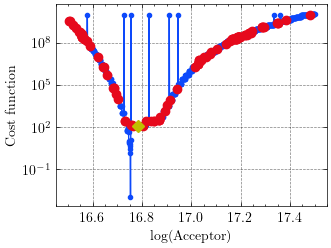

In [114]:
min_y_line = np.min(y_line)
min_y_data = np.min(y_data)
min_y_opt = np.min(y_opt)

min_global = np.min([min_y_line, min_y_data, min_y_opt])

y_line = y_line - min_global + 1e-3
y_data = y_data - min_global + 1e-3
y_opt = y_opt - min_global + 1e-3

print(f"y_opt: {y_data}")
fig, axs = plt.subplots(1, 1)
axs.plot(x_line, y_line, ".-", label="Cost function")
axs.plot(x_data, y_data, "o", label="Data")
axs.plot(x_opt, y_opt, "D", label="Optimum", c="y")

axs.set_xlabel("log(Acceptor)")
axs.set_ylabel("Cost function")
axs.set_yscale("log")